Load data

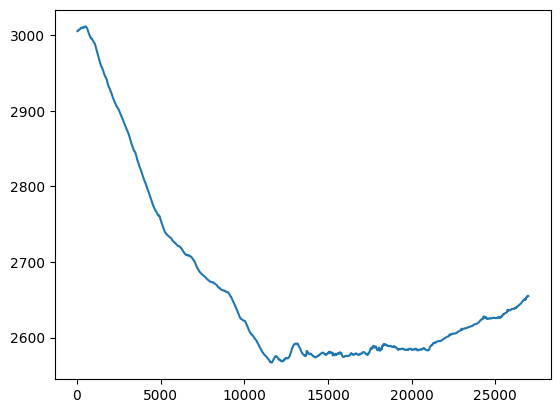

0.13663434982299805 ms


In [76]:
#add libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utm
import time as time
start = time.time()
#add data
datos = pd.read_csv("datasets/Viajes MEX-TOL.csv")
#convert to utm
latitudes = np.array(datos["latitud"])
longitudes = np.array(datos["longitud"])
utms = utm.from_latlon(latitudes,longitudes,14,"Q") #14Q for Mexico
datos_f = datos.copy()
datos_f["utm_x"] = utms[0]
datos_f["utm_y"] = utms[1]


min_longitud = -99.64
max_longitud = -99.39
datos_f = datos_f[datos_f['longitud'] > min_longitud]
datos_f = datos_f[datos_f['longitud'] < max_longitud]
datos_f = datos_f[datos_f['longitud'] < max_longitud]
datos_f = datos_f.reset_index()

datos_f = datos_f.drop(["l","latitud","longitud","fecha","hora"],axis=1)
datos_f = datos_f.rename(columns={"altitud": "height"})
#lag point coordinates
datos_l = datos_f.copy()
datos_l["next_utm_x"] = datos_f["utm_x"].shift(-1)
datos_l["next_utm_y"] = datos_f["utm_y"].shift(-1)
datos_l["next_height"] = datos_f["height"].shift(-1)
#calculate distances and slopes
datos_l["distance"] = np.sqrt((datos_l["utm_x"]-datos_l["next_utm_x"])**2 + (datos_l["utm_y"]-datos_l["next_utm_y"])**2)
datos_l["slope"] = (datos_l["next_height"]-datos_l["height"])/datos_l["distance"] 
datos_l["sum_distance"] = np.cumsum(datos_l["distance"])
plt.plot(datos_l["sum_distance"],datos_l["height"])
plt.show()    
datos_l.head(10)
stop = time.time()
print(stop-start,"ms")

Clustering

In [77]:
import seaborn as sns

In [78]:
def sdd_clust(data, tol):
    heights = data["height"]
    clusters = np.ones(len(heights))
    sdd_cluster=1
    dist = 0
    for i in range(1,len(heights)):
        dist = abs(heights[i-1]-heights[i])
        if dist>tol:
            sdd_cluster = sdd_cluster+1
        clusters[i] = sdd_cluster  

    data["cluster"] = clusters
    return data

In [79]:
def tol_adjust (data, tol=1.6):
  n = 1
  while n>0 :
    tol = tol + 0.1
    data2 = sdd_clust(data, tol)
    frec = data2.cluster.value_counts().to_numpy()
    n = frec[frec<2].shape[0]
  print(tol)
  return data2
   


2.600000000000001


,secuencia,height,utm_x,utm_y,distance,slope,sum_distance,cluster
0,16159,3005.483154,459005.271210,2.134010e+06,26.196697,0.007549,26.196697,1.0
1,16160,3005.680908,458979.520032,2.134006e+06,26.299943,0.036194,52.496640,1.0
2,16161,3006.632813,458953.663777,2.134001e+06,25.826705,0.026024,78.323345,1.0
3,16162,3007.304932,458928.228505,2.133996e+06,25.685182,0.002766,104.008527,1.0
4,16163,3007.375977,458902.898782,2.133992e+06,25.393590,0.014268,129.402118,1.0


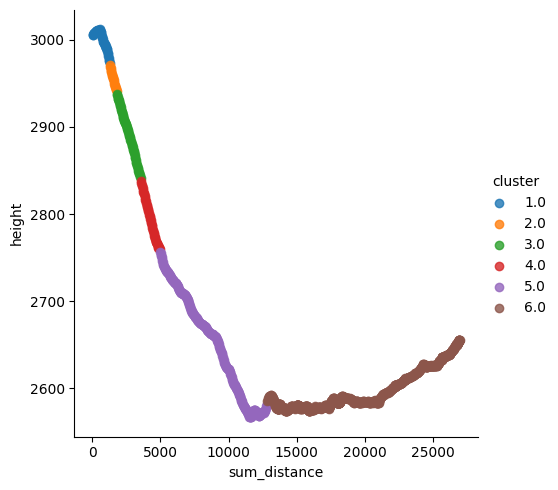

In [80]:
data_clustered = tol_adjust(datos_l, 1.6)
sns.lmplot(x='sum_distance', y='height', data=data_clustered, hue='cluster', fit_reg=False)
data_clustered = data_clustered.drop(['next_utm_x','next_utm_y', 'next_height', 'index' ], axis=1)
data_clustered.reset_index()
data_clustered.head(5)

In [74]:
from sklearn.linear_model import LinearRegression

def height_correction(data_clustered, max_points=5,replace_points=10):
    clusters = data_clustered.cluster.unique()
    if(len(clusters)>1):
        gps_smooth = pd.DataFrame()
        for i in range(1,len(clusters)):

            grupo1 = data_clustered[data_clustered['cluster']==i]
            grupo2 = data_clustered[data_clustered['cluster']==(i+1)]
            grupo1.insert(5,"grupo",np.ones(grupo1.shape[0])); 
            grupo2.insert(5,"grupo",np.ones(grupo2.shape[0])); 
            m = np.min([grupo1.shape[0],grupo2.shape[0],max_points])
            subgrupo1 = grupo1.tail(m)
            subgrupo2 = grupo2.head(m)

            r = pd.concat([subgrupo1,subgrupo2]).reset_index(drop=True)
            modelo_z = LinearRegression().fit(r[['sum_distance']],r[['height']])
            modelo_x = LinearRegression().fit(r[['sum_distance']],r[['utm_x']])
            modelo_y = LinearRegression().fit(r[['sum_distance']],r[['utm_y']])
            
            #200 -100 /5
            #100 200:  100 120 140 160 180 200
            #reemplazar con suavizado
            x_min = r.sum_distance.min()
            x_max = r.sum_distance.max()
            gap_points = pd.DataFrame({'sum_distance':np.linspace(r.sum_distance.min(),r.sum_distance.max(),replace_points)})
          
            h_smooth = modelo_z.predict(gap_points[['sum_distance']])                       
            gap_points['height']=h_smooth  
         
            x_smooth = modelo_x.predict(gap_points[['sum_distance']])
            gap_points['utm_x']=x_smooth
            y_smooth = modelo_y.predict(gap_points[['sum_distance']])
            gap_points['utm_y']=y_smooth
            gap_points['secuencia']=0
            gap_points['distance']=0
            gap_points['slope']=0
            gap_points['cluster']=0
            
            if i==1:
                start = 0
            else:
                start = m + 1
         
            if i>1:
                gps_smooth = gps_smooth[~(gps_smooth['cluster'] == i)]
            
            if grupo2.shape[0]>m: #0 1 2 3 4 5 6 7 8 9
                gps_smooth = pd.concat([gps_smooth, grupo1[start:(grupo1.shape[0] - (m+1))], gap_points, grupo2[(m):(grupo2.shape[0]-1)]])
            else:
                gps_smooth <- pd.concat([gps_smooth,grupo1[start:(grupo1.shape[0] - (m+1))],gap_points])       
        # gps_smooth <- get_distances(gps_smooth)
        # gps_smooth.grupo <- NULL
        # gps_smooth.secuencia <- NULL
        # gps5 <- sddclust(gps_smooth,tolerance=tol)        
    else:
        print("ERROR: No gaps found (clusters number must be longer than 1")
    datos_l = gps_smooth.copy()
    datos_l["next_utm_x"] = datos_l["utm_x"].shift(-1)
    datos_l["next_utm_y"] = datos_l["utm_y"].shift(-1)
    datos_l["next_height"] = datos_l["height"].shift(-1)
    #calculate distances and slopes
    datos_l["distance"] = np.sqrt((datos_l["utm_x"]-datos_l["next_utm_x"])**2 + (datos_l["utm_y"]-datos_l["next_utm_y"])**2)
    datos_l["slope"] = (datos_l["next_height"]-datos_l["height"])/datos_l["distance"] 
    datos_l["sum_distance"] = np.cumsum(datos_l["distance"])
    return(datos_l.reset_index())

,index,secuencia,height,utm_x,utm_y,distance,grupo,slope,sum_distance,cluster,next_utm_x,next_utm_y,next_height
0,0,16159,3005.483154,459005.271210,2.134010e+06,26.196697,1.0,0.007549,26.196697,1.0,458979.520032,2.134006e+06,3005.680908
1,1,16160,3005.680908,458979.520032,2.134006e+06,26.299943,1.0,0.036194,52.496640,1.0,458953.663777,2.134001e+06,3006.632813
2,2,16161,3006.632813,458953.663777,2.134001e+06,25.826705,1.0,0.026024,78.323345,1.0,458928.228505,2.133996e+06,3007.304932
3,3,16162,3007.304932,458928.228505,2.133996e+06,25.685182,1.0,0.002766,104.008527,1.0,458902.898782,2.133992e+06,3007.375977
4,4,16163,3007.375977,458902.898782,2.133992e+06,25.393590,1.0,0.014268,129.402118,1.0,458877.883983,2.133988e+06,3007.738281


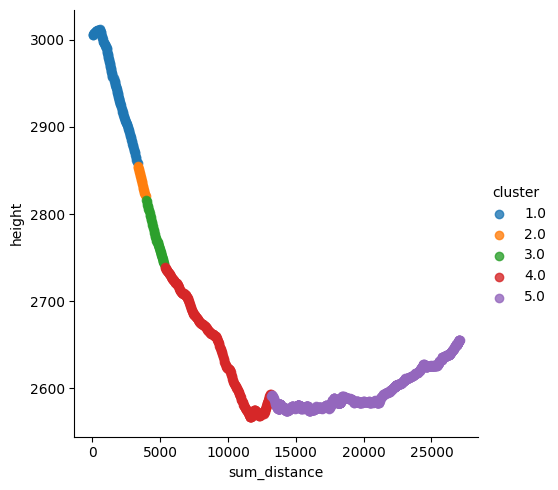

In [81]:
data_smooth = height_correction(data_clustered,10,30)
data_clustered2 = sdd_clust(data_smooth, 2.6)
sns.lmplot(x='sum_distance', y='height', data=data_clustered2, hue='cluster', fit_reg=False)
data_clustered2.reset_index()
data_clustered2.head(5)